## **Import Libraries**

In [18]:
import os
import tensorflow as tf
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
try:
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    strategy = tf.distribute.TPUStrategy(resolver)
    print(f"Number of devices: {strategy.num_replicas_in_sync} TPU devices")
except:
    physical_devices = tf.config.list_physical_devices("GPU")
    if len(physical_devices) > 0:
        tf.config.set_visible_devices(physical_devices, "GPU")
        strategy = tf.distribute.MultiWorkerMirroredStrategy()
        print(f"Number of devices: {strategy.num_replicas_in_sync} GPU devices")
    else:
        strategy = tf.distribute.get_strategy()
        print(f"Number of devices: {strategy.num_replicas_in_sync} CPU devices")

Number of devices: 1 GPU devices


## **Load The Data**

In [3]:
try:
    import google.colab
    if not os.path.exists("vehicles"):
        !git clone "https://github.com/denis-spe/vehicles"

    # Directory of dataset
    data_dir = "vehicles/vehicles"
except:
    # Directory of dataset
    data_dir = "vehicles"

Cloning into 'vehicles'...
remote: Enumerating objects: 104, done.
remote: Counting objects: 100% (104/104), done.
remote: Compressing objects: 100% (100/100), done.
remote: Total 104 (delta 10), reused 87 (delta 2), pack-reused 0
Receiving objects: 100% (104/104), 12.70 MiB | 18.06 MiB/s, done.
Resolving deltas: 100% (10/10), done.


In [4]:
# Seed for reproducible
seed = 123

# batch size
batch_size = 1 * strategy.num_replicas_in_sync

# image shape
img_height = 300
img_width = 300

train_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="training",
            seed=seed,
            image_size=(img_width, img_height),
            batch_size=batch_size,
            label_mode='categorical'
        )

val_ds = keras.utils.image_dataset_from_directory(
            data_dir,
            validation_split=0.2,
            subset="validation",
            seed=seed,
            image_size=(img_width, img_height),
            batch_size=batch_size,
            label_mode='categorical'
        )

Found 196 files belonging to 4 classes.
Using 157 files for training.
Found 196 files belonging to 4 classes.
Using 39 files for validation.


# **Get To Know The Data**

In [5]:
classes = train_ds.class_names
classes

['bus', 'car', 'motorbike', 'truck']

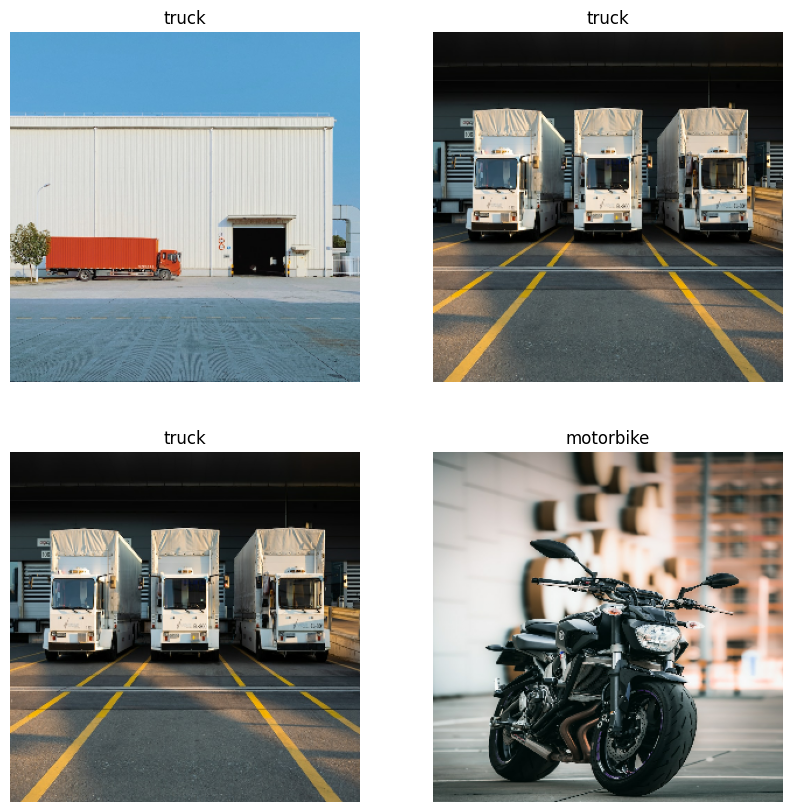

In [6]:
# Create a figure
fig = plt.figure(figsize=(10, 10))

# Number of rows and columns
NROW = 2
NCOL = 2

for i in range(NROW + NCOL):
    img, label = next(iter(train_ds.as_numpy_iterator()))

    fig.add_subplot(NROW, NCOL, i + 1)

    plt.imshow(tf.squeeze(img) / 255)
    plt.axis("off")
    plt.title(classes[tf.argmax(label[0]).numpy()])


In [7]:
img, label = next(iter(train_ds.as_numpy_iterator()))

In [8]:
img_shape = img.shape[1:]
img_shape

(300, 300, 3)

## **Model Building**

In [9]:
with strategy.scope():
    # Input layer
    input_layer = layers.Input(img_shape)
    # Flatten the data
    flatten_layer = layers.Flatten()(input_layer)
    # Hidden layer One
    hidden_layer_1 = layers.Dense(1029, activation="relu")(flatten_layer)
    # output layer
    output_layer = layers.Dense(4, activation="softmax")(hidden_layer_1)

    # Instantiate the Model object
    model = keras.Model(input_layer, output_layer)

    # Print the model summary
    model.summary()

    # Compile the model
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = keras.optimizers.Adam(),
        metrics = [
            keras.metrics.Accuracy()
        ]
    )

    # Fit the model
    model.fit(
     train_ds,
     epochs=1,
     validation_data=val_ds,
     batch_size=batch_size
    )

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 flatten (Flatten)           (None, 270000)            0         
                                                                 
 dense (Dense)               (None, 1029)              277831029 
                                                                 
 dense_1 (Dense)             (None, 4)                 4120      
                                                                 
Total params: 277835149 (1.04 GB)
Trainable params: 277835149 (1.04 GB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
157/157 [==============================] - 17s 91ms/step - loss: 102363.1094 - accuracy: 0.6911 - val_loss: 23473.7988 - val_accuracy: 0.7821


In [10]:
model.save("model.keras")

In [11]:
saved_model = keras.models.load_model("model.keras")

In [13]:
saved_model.evaluate(val_ds)

39/39 [==============================] - 1s 12ms/step - loss: 23473.8008 - accuracy: 0.7821


[23473.80078125, 0.7820512652397156]

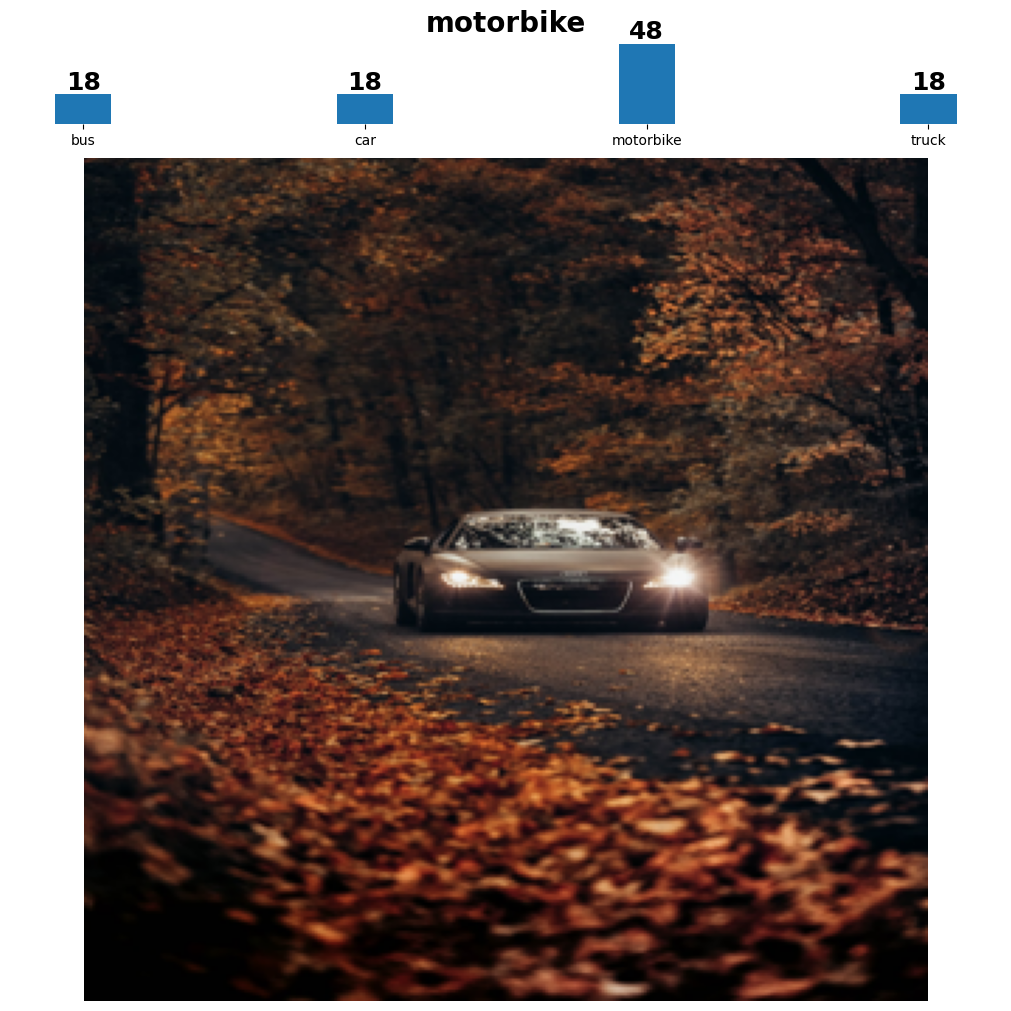

In [149]:
img = Image.open(os.path.join(data_dir, "car/img-100.jpeg"))
resized_img = np.array(img.resize((300, 300)))

# Expand image dimensions
expand_dim_img = np.expand_dims(resized_img, axis=0)

# Make prediction
pred = saved_model.predict(expand_dim_img, verbose=0)

# Model prediction probabilities
probabilities = np.ceil(tf.nn.softmax(pred).numpy() * 100).astype("int")[0]

# Select the classes by prediction as index
label = classes[pred.argmax()]

fig, ax = plt.subplots(
   2, 1,
   figsize=(10, 10),
   constrained_layout=True,
   gridspec_kw={"height_ratios": [0.2, 2]}
 )


bar = ax[0].bar(classes, probabilities, width=0.2)
ax[0].bar_label(bar, probabilities, size=18, weight=700)
ax[0].set_title(label, weight=700, size=20)
for side in ['top', 'right', 'left', 'bottom']:
     ax[0].spines[side].set_visible(False)
ax[0].set_yticks([])


ax[1].imshow(resized_img)
ax[1].axis("off")
plt.show()